In [4]:
import re
import csv
# import nltk
import string
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

In [5]:
# Confirm that the GPU is detected
torch.cuda.is_available()

True

In [6]:
# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla T4, n_gpu: 2


In [67]:
# device = "cuda:0" if torch.cuda.is_available() else "cpu"

## Loading the preprocessed dataset

In [13]:
tweet_df = pd.read_csv("/kaggle/input/processed-data/Preprocessed_Data_Final.csv")
tweet_df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
tweet_df.rename(columns={'new_class': 'label', 'cleaned_tweet': 'clean_tweet'}, inplace=True)

In [14]:
tweet_df.head()

,count,hate_speech,offensive_language,neither,class,tweet,AAVE_hate_speech,AAVE,label,clean_tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,0,0,0,!!! RT : As a woman you shouldn't complain abo...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,0,0,0,!!!!! RT : boy dats cold...tyga dwn bad for cu...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,0,0,0,!!!!!!! RT Dawg!!!! RT : You ever fuck a bitch...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,0,0,0,!!!!!!!!! RT : she look like a tranny
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,0,0,0,!!!!!!!!!!!!! RT : The shit you hear about me ...


In [15]:
tweet_df.groupby(by='AAVE').size()

AAVE
0    23583
1     1201
dtype: int64

<Axes: >

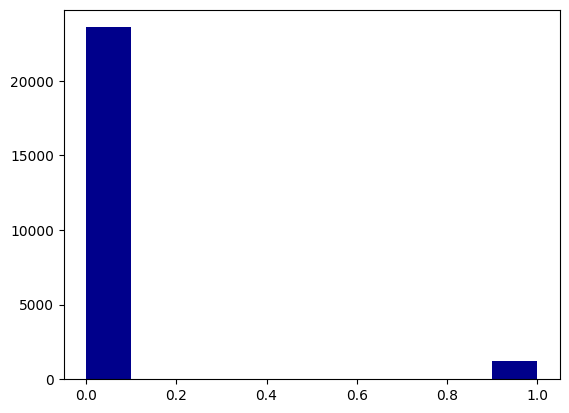

In [16]:
tweet_df['AAVE'].hist(color='darkblue', grid=False)

## A) Qualitative Debiasing  [*Pre-processing Stage*]

Create an updated_label field with the new hate speech label according to the Human-in-the-loop annotations

In [17]:
def update_class_after_debias(row):
    if (row['AAVE'] == 1) and (row['AAVE_hate_speech'] == 1) :
        return 1
    else:
        return row['label']

In [18]:
tweet_df['updated_label'] = tweet_df.apply(update_class_after_debias, axis=1)

In [ ]:
tweet_df['label'].sum(), tweet_df['updated_label'].sum()

In [ ]:
import matplotlib.pyplot as plt

# orig_groups = tweet_df.groupby(['AAVE', 'label']).size().reset_index(name='count')
# updt_groups = tweet_df.groupby(['AAVE', 'updated_label']).size().reset_index(name='count')
# plt.bar(orig_groups['AAVE'], orig_groups['count'])
# plt.bar(updt_groups['AAVE'], updt_groups['count'])

axes = tweet_df.hist(['label','updated_label'], by='AAVE', legend=True,
#                      bins=10, layout=(2,2), 
#                      yrot=90, sharex=True, sharey=True
                    )
for ax in axes.flatten():
    ax.set_xlabel('Hate Speech Class')
    ax.set_ylabel('Count')

## B) Dialect Debiasing [*In-processing Stage*]

### AAE-to-SAE translation using Fine-tuned mBART

In [35]:
# Load the saved fine-tuned mBART model from disk

fname1 = 'mbart_translate_5epochs.sav'
fpath1 = '/kaggle/working/' + fname1
translation_model = pickle.load(open(fpath1, 'rb'))

In [39]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('facebook/mbart-large-en-ro')

In [40]:
def translate_aae_to_sae(sentence, model, tokenizer, device='cuda'):
    # Move the model to the specified device
    model.to(device)

    # Tokenize the input sentence
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Move the input tensors to the same device as the model
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Generate translation output
    output_sequences = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=256,
    )

    # Decode the output
    translated_sentence = tokenizer.decode(output_sequences[0], skip_special_tokens=True)
    return translated_sentence

### Use this model to translate AAE samples in our data 

In [19]:
def apply_translation(row):
    if row['AAVE'] == 1:
        return translate_aae_to_sae(row['clean_tweet'], translation_model, tokenizer)
    else:
        return row['clean_tweet']

In [ ]:
tweet_df['SAE_tweet'] = tweet_df.apply(apply_translation, axis=1)

In [ ]:
tweet_df.isnull().sum()

In [ ]:
tweet_df.dropna(inplace = True)

In [ ]:
tweet_df.isnull().sum()

In [26]:
tweet_df.to_csv('processed_tweets_with_sae.csv')

## Fine-tuning DistilRoBERTa model to detect hate speech

In [7]:
# Load the processed data with the AAE to SAE translations

data = pd.read_csv('/kaggle/input/processed-dataset/processed_tweets_with_sae.csv')
data.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [8]:
data.head()

,count,hate_speech,offensive_language,neither,class,tweet,AAVE_hate_speech,AAVE,label,clean_tweet,updated_label,SAE_tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,0,0,0,!!! RT : As a woman you shouldn't complain abo...,0,!!! RT : As a woman you shouldn't complain abo...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,0,0,0,!!!!! RT : boy dats cold...tyga dwn bad for cu...,0,!!!!! RT : boy dats cold...tyga dwn bad for cu...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,0,0,0,!!!!!!! RT Dawg!!!! RT : You ever fuck a bitch...,0,!!!!!!! RT Dawg!!!! RT : You ever fuck a bitch...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,0,0,0,!!!!!!!!! RT : she look like a tranny,0,!!!!!!!!! RT : she look like a tranny
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,0,0,0,!!!!!!!!!!!!! RT : The shit you hear about me ...,0,!!!!!!!!!!!!! RT : The shit you hear about me ...


In [9]:
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

In [10]:
from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, 
                          Trainer, 
                          TrainingArguments)

tokenizer = AutoTokenizer.from_pretrained("distilroberta-base", device_map="auto")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [11]:
def tokenize_data(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, return_tensors="pt")

In [12]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [13]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

### Case 0: Prediction on original dataset with original label

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data, data['label'], test_size=0.2, random_state=42)

# Tokenize the training and testing data
train_encodings = tokenize_data(X_train['clean_tweet'])
test_encodings = tokenize_data(X_test['clean_tweet'])
y_train_tensor = torch.tensor(y_train.values)
y_test_tensor = torch.tensor(y_test.values)

train_dataset = TextDataset(train_encodings, y_train_tensor)
test_dataset = TextDataset(test_encodings, y_test_tensor)

In [15]:
len(train_dataset), len(test_dataset)

(19826, 4957)

In [16]:
X_test.head()

,count,hate_speech,offensive_language,neither,class,tweet,AAVE_hate_speech,AAVE,label,clean_tweet,updated_label,SAE_tweet
2281,3,0,3,0,1,934 8616\ni got a missed call from yo bitch,0,0,0,i got a missed call from yo bitch,0,i got a missed call from yo bitch
15914,6,0,6,0,1,RT @KINGTUNCHI_: I don't understand if all the...,0,0,0,RT : I don't understand if all these hoes say ...,0,RT : I don't understand if all these hoes say ...
18943,6,1,5,0,1,RT @eanahS__: I done had EVERYTHING you hoes e...,0,1,0,RT : I done had EVERYTHING you hoes ever wante...,0,I had done anything you hoes ever wanted. That...
16407,3,0,3,0,1,RT @MayaAngelouFRO: Ready to slay these bitche...,0,0,0,RT : Ready to slay these bitches and im not ev...,0,RT : Ready to slay these bitches and im not ev...
13326,3,0,3,0,1,Niggas cry when they get hit high and cry when...,0,0,0,Niggas cry when they get hit high and cry when...,0,Niggas cry when they get hit high and cry when...


In [17]:
num_labels = 2 
model1 = AutoModelForSequenceClassification.from_pretrained("distilroberta-base", num_labels=num_labels)


training_args = TrainingArguments(
    output_dir='./results',          # output directory for model predictions and checkpoints
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing log
)
trainer1 = Trainer(
    model=model1, 
    args=training_args, 
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
trainer1.train()  # Takes ~10 minutes to run for 5 epochs over ~19.8k training samples

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/tmp/ipykernel_34/2407297667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_34/2407297667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
500,0.221000
1000,0.159300
1500,0.132300
2000,0.121400
2500,0.087500
3000,0.064000


Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/tmp/ipykernel_34/2407297667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_34/2407297667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, b

TrainOutput(global_step=3100, training_loss=0.12873951896544425, metrics={'train_runtime': 562.5323, 'train_samples_per_second': 176.221, 'train_steps_per_second': 5.511, 'total_flos': 1513199415033960.0, 'train_loss': 0.12873951896544425, 'epoch': 5.0})

In [19]:
trainer1.evaluate()

/tmp/ipykernel_34/2407297667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_34/2407297667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


{'eval_loss': 0.27402594685554504,
 'eval_accuracy': 0.9322170667742586,
 'eval_f1': 0.4305084745762712,
 'eval_precision': 0.46691176470588236,
 'eval_recall': 0.39937106918238996,
 'eval_runtime': 5.1099,
 'eval_samples_per_second': 970.074,
 'eval_steps_per_second': 7.632,
 'epoch': 5.0}

In [20]:
# Save the model to disk

fname0 = 'distilroberta_case0_5epochs.sav'
pickle.dump(model0, open(fname0, 'wb'))

In [21]:
# Get the file download link manually 

%cd /kaggle/working

from IPython.display import FileLink 
FileLink(fname0)

/kaggle/working


/kaggle/working/distilroberta_case1_5epochs.sav

In [135]:
# Load the model from disk
fpath1 = "/kaggle/working/" + fname1
model1 = pickle.load(open(fpath1, 'rb'))

In [22]:
predictions = trainer1.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

/tmp/ipykernel_34/2407297667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_34/2407297667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


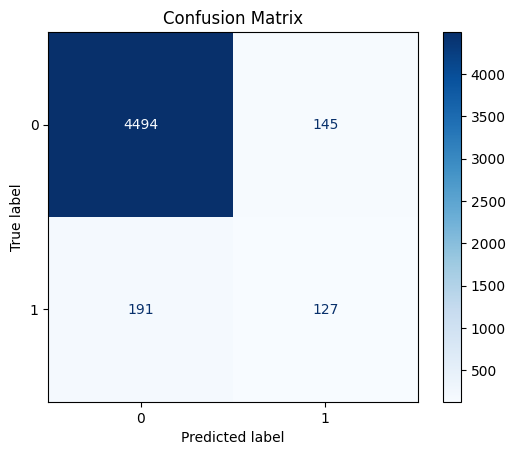

In [23]:
true_labels = predictions.label_ids
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [24]:
accuracy = accuracy_score(true_labels, preds)
print(f"Accuracy: {accuracy}")

# Calculate False Positive Rate from Confusion Matrix
TN = cm[0][0]  # True Negatives
FP = cm[0][1]  # False Positives
FN = cm[1][0]  # False Negatives
TP = cm[1][1]  # True Positives

FPR = FP / float(FP + TN)  
FNR = FN / float(FN + TP)
TPR = TP / float(TP + FN)
print(f"False Positive Rate: {FPR}")
print(f"False Negative Rate: {FNR}")
print(f"True Positive Rate: {TPR}")

Accuracy: 0.9322170667742586
False Positive Rate: 0.03125673636559603
False Negative Rate: 0.60062893081761
True Positive Rate: 0.39937106918238996


## Consider only AAE subset of data 
This is done since AAVE samples are under-represented in the original dataset. Hence the classifier model can just learn the sample distribution to get high accuracy predictions. To avoid this I am working with the AAE samples specifically (~1200 samples)

In [25]:
data = data[data["AAVE"]==1]
len(data)

1201

### Case 1: Prediction on original AAE text with original label

In [26]:
CASE_NUM = 1

# Split data into trian and test
X_train, X_test, y_train, y_test = train_test_split(data, data['label'], test_size=0.2, random_state=42)


# Tokenize the training and testing data
train_encodings = tokenize_data(X_train['clean_tweet'])
test_encodings = tokenize_data(X_test['clean_tweet'])
y_train_tensor = torch.tensor(y_train.values)
y_test_tensor = torch.tensor(y_test.values)

train_dataset = TextDataset(train_encodings, y_train_tensor)
test_dataset = TextDataset(test_encodings, y_test_tensor)
print(len(train_dataset), len(test_dataset))


# Initialize the model
num_labels = 2 
model = AutoModelForSequenceClassification.from_pretrained("distilroberta-base", num_labels=num_labels)

training_args = TrainingArguments(
    output_dir='./results',          # output directory for model predictions and checkpoints
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing log
)
trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.evaluate()


# Save the model to disk
fname = 'distilroberta_case' + str(CASE_NUM) + '_5epochs.sav'
pickle.dump(model, open(fname, 'wb'))

960 241


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_34/2407297667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_34/2407297667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
/opt/conda/lib/python3.10/site-packages/tor

Step,Training Loss


In [27]:
# Get the file download link manually 

%cd /kaggle/working

from IPython.display import FileLink 
FileLink(fname)

/kaggle/working


/kaggle/working/distilroberta_case1_5epochs.sav

/tmp/ipykernel_34/2407297667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_34/2407297667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


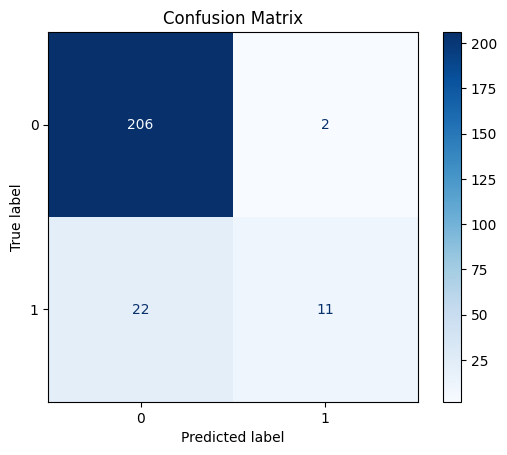

Accuracy: 0.9004149377593361
False Positive Rate: 0.009615384615384616
False Negative Rate: 0.6666666666666666
True Positive Rate: 0.3333333333333333


In [28]:
# Predict hate speech on test dataset 
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

true_labels = predictions.label_ids
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(true_labels, preds)
print(f"Accuracy: {accuracy}")

# Calculate False Positive Rate from Confusion Matrix
TN = cm[0][0]  # True Negatives
FP = cm[0][1]  # False Positives
FN = cm[1][0]  # False Negatives
TP = cm[1][1]  # True Positives
FPR = FP / float(FP + TN)  
FNR = FN / float(FN + TP)
TPR = TP / float(TP + FN)
print(f"False Positive Rate: {FPR}")
print(f"False Negative Rate: {FNR}")
print(f"True Positive Rate: {TPR}")

### Case 2: Predict on original AAE text with updated labels

In [29]:
CASE_NUM = 2

# Split data into trian and test
X_train, X_test, y_train, y_test = train_test_split(data, data['updated_label'], test_size=0.2, random_state=42)


# Tokenize the training and testing data
train_encodings = tokenize_data(X_train['clean_tweet'])
test_encodings = tokenize_data(X_test['clean_tweet'])
y_train_tensor = torch.tensor(y_train.values)
y_test_tensor = torch.tensor(y_test.values)

train_dataset = TextDataset(train_encodings, y_train_tensor)
test_dataset = TextDataset(test_encodings, y_test_tensor)
print(len(train_dataset), len(test_dataset))


# Initialize the model
num_labels = 2 
model = AutoModelForSequenceClassification.from_pretrained("distilroberta-base", num_labels=num_labels)

training_args = TrainingArguments(
    output_dir='./results',          # output directory for model predictions and checkpoints
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing log
)
trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.evaluate()


# Save the model to disk
fname = 'distilroberta_case' + str(CASE_NUM) + '_5epochs.sav'
pickle.dump(model, open(fname, 'wb'))

960 241


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_34/2407297667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_34/2407297667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
/opt/conda/lib/python3.10/site-packages/tor

Step,Training Loss


In [30]:
# Get the file download link manually 

%cd /kaggle/working

from IPython.display import FileLink 
FileLink(fname)

/kaggle/working


/kaggle/working/distilroberta_case2_5epochs.sav

/tmp/ipykernel_34/2407297667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_34/2407297667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


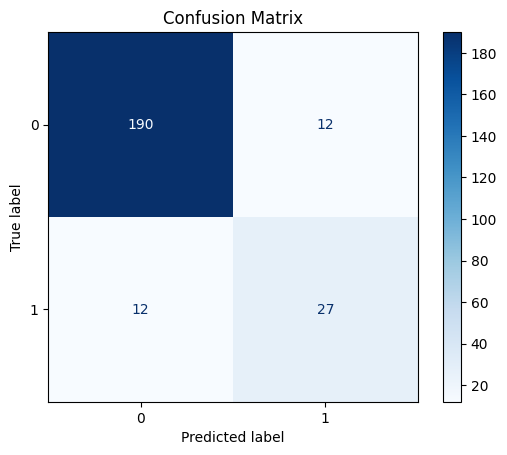

Accuracy: 0.9004149377593361
False Positive Rate: 0.0594059405940594
False Negative Rate: 0.3076923076923077
True Positive Rate: 0.6923076923076923


In [31]:
# Predict hate speech on test dataset 
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

true_labels = predictions.label_ids
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(true_labels, preds)
print(f"Accuracy: {accuracy}")

# Calculate False Positive Rate from Confusion Matrix
TN = cm[0][0]  # True Negatives
FP = cm[0][1]  # False Positives
FN = cm[1][0]  # False Negatives
TP = cm[1][1]  # True Positives
FPR = FP / float(FP + TN)  
FNR = FN / float(FN + TP)
TPR = TP / float(TP + FN)
print(f"False Positive Rate: {FPR}")
print(f"False Negative Rate: {FNR}")
print(f"True Positive Rate: {TPR}")

### Case 3: Predict on translated SAE text with original labels

In [39]:
CASE_NUM = 3

# Split data into trian and test
X_train, X_test, y_train, y_test = train_test_split(data, data['label'], test_size=0.2, random_state=40)


# Tokenize the training and testing data
train_encodings = tokenize_data(X_train['SAE_tweet'])
test_encodings = tokenize_data(X_test['SAE_tweet'])
y_train_tensor = torch.tensor(y_train.values)
y_test_tensor = torch.tensor(y_test.values)

train_dataset = TextDataset(train_encodings, y_train_tensor)
test_dataset = TextDataset(test_encodings, y_test_tensor)
print(len(train_dataset), len(test_dataset))


# Initialize the model
num_labels = 2 
model = AutoModelForSequenceClassification.from_pretrained("distilroberta-base", num_labels=num_labels)

training_args = TrainingArguments(
    output_dir='./results',          # output directory for model predictions and checkpoints
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing log
)
trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.evaluate()


# Save the model to disk
fname = 'distilroberta_case' + str(CASE_NUM) + '_5epochs.sav'
pickle.dump(model, open(fname, 'wb'))

960 241


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_34/2407297667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_34/2407297667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
/opt/conda/lib/python3.10/site-packages/tor

Step,Training Loss


In [40]:
# Get the file download link manually 

%cd /kaggle/working

from IPython.display import FileLink 
FileLink(fname)

/kaggle/working


/kaggle/working/distilroberta_case3_5epochs.sav

/tmp/ipykernel_34/2407297667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_34/2407297667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


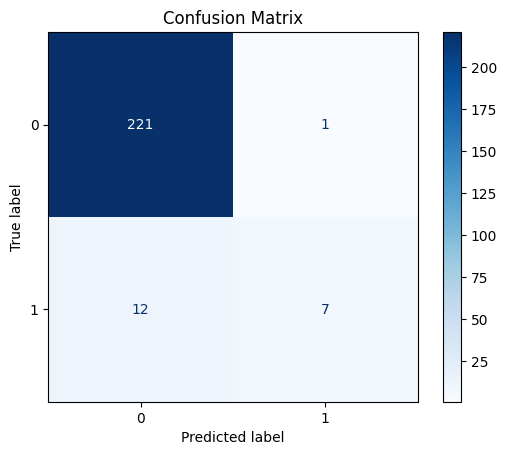

Accuracy: 0.946058091286307
False Positive Rate: 0.0045045045045045045
False Negative Rate: 0.631578947368421
True Positive Rate: 0.3684210526315789


In [41]:
# Predict hate speech on test dataset 
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

true_labels = predictions.label_ids
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(true_labels, preds)
print(f"Accuracy: {accuracy}")

# Calculate False Positive Rate from Confusion Matrix
TN = cm[0][0]  # True Negatives
FP = cm[0][1]  # False Positives
FN = cm[1][0]  # False Negatives
TP = cm[1][1]  # True Positives
FPR = FP / float(FP + TN)  
FNR = FN / float(FN + TP)
TPR = TP / float(TP + FN)
print(f"False Positive Rate: {FPR}")
print(f"False Negative Rate: {FNR}")
print(f"True Positive Rate: {TPR}")

### Case 4: Predict on translated SAE text with updated labels

In [50]:
CASE_NUM = 4

# Split data into trian and test
X_train, X_test, y_train, y_test = train_test_split(data, data['updated_label'], test_size=0.2, random_state=40)


# Tokenize the training and testing data
train_encodings = tokenize_data(X_train['SAE_tweet'])
test_encodings = tokenize_data(X_test['SAE_tweet'])
y_train_tensor = torch.tensor(y_train.values)
y_test_tensor = torch.tensor(y_test.values)

train_dataset = TextDataset(train_encodings, y_train_tensor)
test_dataset = TextDataset(test_encodings, y_test_tensor)
print(len(train_dataset), len(test_dataset))


# Initialize the model
num_labels = 2 
model = AutoModelForSequenceClassification.from_pretrained("distilroberta-base", num_labels=num_labels)

training_args = TrainingArguments(
    output_dir='./results',          # output directory for model predictions and checkpoints
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing log
)
trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.evaluate()


# Save the model to disk
fname = 'distilroberta_case' + str(CASE_NUM) + '_5epochs.sav'
pickle.dump(model, open(fname, 'wb'))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


960 241


/tmp/ipykernel_34/2407297667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_34/2407297667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


In [37]:
# Get the file download link manually 

%cd /kaggle/working

from IPython.display import FileLink 
FileLink(fname)

/kaggle/working


/kaggle/working/distilroberta_case4_5epochs.sav

/tmp/ipykernel_34/2407297667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_34/2407297667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


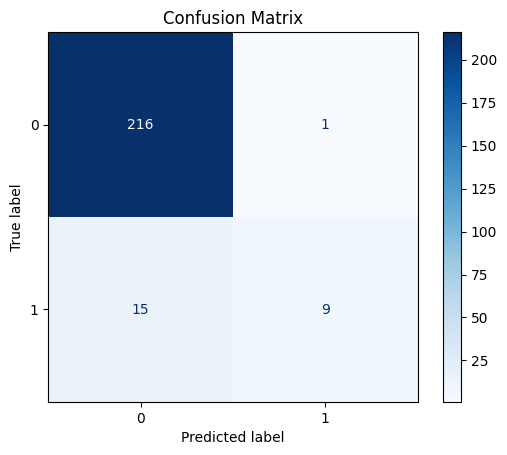

Accuracy: 0.9336099585062241
False Positive Rate: 0.004608294930875576
False Negative Rate: 0.625
True Positive Rate: 0.375


In [51]:
# Predict hate speech on test dataset 
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

true_labels = predictions.label_ids
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(true_labels, preds)
print(f"Accuracy: {accuracy}")

# Calculate False Positive Rate from Confusion Matrix
TN = cm[0][0]  # True Negatives
FP = cm[0][1]  # False Positives
FN = cm[1][0]  # False Negatives
TP = cm[1][1]  # True Positives
FPR = FP / float(FP + TN)  
FNR = FN / float(FN + TP)
TPR = TP / float(TP + FN)
print(f"False Positive Rate: {FPR}")
print(f"False Negative Rate: {FNR}")
print(f"True Positive Rate: {TPR}")

# Future Work

## Fine-tuning DistilRoberta-base

### Create a bias-aware loss function

In [16]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss, MSELoss
from torch.nn import functional as F

import transformers 
from transformers.models.bert.modeling_bert import BertEmbeddings, BertModel, BertPreTrainedModel
from transformers import RobertaConfig, RobertaModel
from transformers.file_utils import add_start_docstrings

In [17]:
ROBERTA_PRETRAINED_MODEL_ARCHIVE_MAP = {
    'roberta-base': "https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-pytorch_model.bin",
    'roberta-large': "https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-pytorch_model.bin",
    'roberta-large-mnli': "https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-mnli-pytorch_model.bin",
    'distilroberta-base': "https://s3.amazonaws.com/models.huggingface.co/bert/distilroberta-base-pytorch_model.bin",
    'roberta-base-openai-detector': "https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-openai-detector-pytorch_model.bin",
    'roberta-large-openai-detector': "https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-openai-detector-pytorch_model.bin",
}

In [28]:
class RobertaForDebiasSequenceClassification(BertPreTrainedModel):
    
    config_class = RobertaConfig
    pretrained_model_archive_map = ROBERTA_PRETRAINED_MODEL_ARCHIVE_MAP
    base_model_prefix = "roberta"

    def __init__(self, config):
        super(RobertaForDebiasSequenceClassification, self).__init__(config)
        self.num_labels = config.num_labels

        self.roberta = RobertaModel(config)
        self.classifier = RobertaClassificationHead(config)
        
        self.bias_lin = torch.nn.Linear(1024, 1)
    
    def debias_loss(self, hidden, logits, bias, labels, penalty=0.01):

        logits = logits.float()  # In case we were in fp16 mode
        hidden = hidden[:, 0, :] # Take <s>, the same as CLS token
        logits = F.log_softmax(logits, 1)

        factor = self.bias_lin.forward(hidden)
        factor = factor.float()
        factor = F.softplus(factor)
        bias = bias * factor

        bias_lp = F.log_softmax(bias, 1)
        entropy = -(torch.exp(bias_lp) * bias_lp).sum(1).mean(0)

        loss = F.cross_entropy(logits + bias, labels) + penalty*entropy
        return loss
        #return loss, logits+bias

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, inputs_embeds=None,
                labels=None, bias=None):
        outputs = self.roberta(input_ids,
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids,
                               position_ids=position_ids,
                               head_mask=head_mask,
                               inputs_embeds=inputs_embeds)
        sequence_output = outputs[0]
        logits = self.classifier(sequence_output)

        outputs = (logits,) + outputs[2:]
        #outputs = outputs[2:]
        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            elif bias is None:
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            else:
                loss = self.debias_loss(sequence_output, logits, bias, labels)
            outputs = (loss,) + outputs
            #outputs = (loss, logits_bias,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [29]:
class RobertaClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config):
        super(RobertaClassificationHead, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features[:, 0, :]  # take <s> token (equiv. to [CLS])
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

In [ ]:
num_labels = 2  # Adjust based on your task
model = RobertaForDebiasSequenceClassification("distilroberta-base", num_labels=num_labels)


training_args = TrainingArguments(
    output_dir='./results',          # output directory for model predictions and checkpoints
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing log
)
trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
# Training Parameters 

FT_EPOCHS = 4
BATCH_SIZE = 64
NUM_STEPS = len(X_train.index)

In [ ]:
# Unfreeze distilBERT layers and make available for training
for layer in distilBERT.layers:
    layer.trainable = True
    
# Recompile model after unfreezing
model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5), 
              loss=focal_loss(),
              metrics=['accuracy'])

# Train the model
train_history2 = model.fit(
    x = [X_train_ids, X_train_attention],
    y = y_train.to_numpy(),
    epochs = FT_EPOCHS,
    batch_size = BATCH_SIZE,
    steps_per_epoch = NUM_STEPS,
    validation_data = ([X_valid_ids, X_valid_attention], y_valid.to_numpy()),
    verbose=2
)

In [37]:
# Define the maximum number of words to tokenize (DistilBERT can tokenize up to 512)
MAX_LENGTH = 128


import tensorflow as tf 

# Define function to encode text data in batches
def batch_encode(tokenizer, texts, batch_size=256, max_length=MAX_LENGTH):
    """""""""
    A function that encodes a batch of texts and returns the texts'
    corresponding encodings and attention masks that are ready to be fed 
    into a pre-trained transformer model.
    
    Input:
        - tokenizer:   Tokenizer object from the PreTrainedTokenizer Class
        - texts:       List of strings where each string represents a text
        - batch_size:  Integer controlling number of texts in a batch
        - max_length:  Integer controlling max number of words to tokenize in a given text
    Output:
        - input_ids:       sequence of texts encoded as a tf.Tensor object
        - attention_mask:  the texts' attention mask encoded as a tf.Tensor object
    """""""""
    
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=max_length,
                                             padding='longest', #implements dynamic padding
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_token_type_ids=False
                                             )
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])
    
    
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)

In [ ]:
# Encode X_train
X_train_ids, X_train_attention = batch_encode(tokenizer, X_train['clean_tweet'].tolist())

# Encode X_test
X_test_ids, X_test_attention = batch_encode(tokenizer, X_test['clean_tweet'].tolist())

### Adverserial training 

In [1]:
import time
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, AdamW, DistilBertModel, DistilBertConfig

In [2]:
def get_max_len(tokenizer, tweets):
    max_length = 0
    for t in tweets:
      ids = tokenizer.encode(t)
      max_length = max(len(ids),max_length)
    return max_length if max_length <= 512 else 512 # The max sequence length for BERT is 512


def tokenize_for_tweet(tokenizer, tweets, labels, max_length):
    input_ids = []
    attention_masks = []

    for t in tweets:
        input_dict = tokenizer.encode_plus(t, add_special_tokens=True, max_length=max_length, truncation=True, padding='max_length', return_tensors='pt')
        input_ids.append(input_dict['input_ids'])
        attention_masks.append(input_dict['attention_mask'])
    input_ids = torch.cat(input_ids,dim=0)
    attention_masks = torch.cat(attention_masks,dim=0)
    labels=torch.tensor(labels)
    dataset = TensorDataset(input_ids, attention_masks, labels)
    return dataset


def run_tokenizer(data, x_col='clean_tweet', y_col='label', test_size=0.3):
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased') 
    
    X_train, X_test, y_train, y_test = train_test_split(data, data[y_col], test_size=test_size, random_state=42)
    train_tweets = X_train[x_col].values
    test_tweets = X_test[x_col].values
    train_labels = y_train.values
    test_labels = y_test.values
    
    max_length = get_max_len(tokenizer, train_tweets)
    train_dataset = tokenize_for_tweet(tokenizer, train_tweets, train_labels, max_length)
    test_dataset = tokenize_for_tweet(tokenizer, test_tweets, test_labels, max_length)
    
    return train_dataset, test_dataset, tokenizer

In [3]:
data_df = pd.read_csv('/kaggle/working/processed_tweets_with_sae.csv')
data = data_df[data_df["AAVE"]==1]
len(data)

1201

In [4]:
train_dataset, test_dataset, tokenizer = run_tokenizer(data, x_col='clean_tweet', 
                                                       y_col='label', test_size=0.3)
len(train_dataset), len(test_dataset)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

(840, 361)

In [5]:
# Make data loader
batch_size = 20
train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size)
test_dataloader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset), batch_size = batch_size)

In [6]:
# Define classifier and adversary
configuration = DistilBertConfig()


class Classifier(nn.Module):
    def __init__(self, num_label):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-cased')
        self.linear = nn.Linear(configuration.hidden_size, num_label)

    def forward(self, input_ids, attention_mask): # input_id [batch_size, sentence_length]
        last_hidden_state = self.bert(input_ids, attention_mask)[0] # last_hidden_state [batch_size, sentence_length, hidden_size]
        last_hidden_state_mean = torch.mean(last_hidden_state, dim=1) # last_hidden_state [batch_size, hidden_size]
        output = self.linear(last_hidden_state_mean) # output [batch_size, num_label]
        return last_hidden_state, last_hidden_state_mean, output


class Adversary(nn.Module):
    def __init__(self, num_protected_label, hidden_size):
        super().__init__()
        self.linear1 = nn.Linear(configuration.hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, num_protected_label)

    def forward(self, clf_last_state):
        output1 = self.linear1(clf_last_state)
        output1_relu = self.relu(output1)
        output = self.linear2(output1_relu)
        return output


def evaluate(clf, test_dataloader):
    num_total, num_correct = 0, 0
    clf.train(False)
    
    with torch.no_grad():
        eval_loss = 0
        true_labels, predict_labels = [], []
        for input, mask, label in test_dataloader:
            clf.zero_grad()
            
            input = input.to(DEVICE)
            mask = mask.to(DEVICE)
            label = label.to(DEVICE)

            last_hidden_state, last_hidden_state_mean, output = clf(input_ids=input, 
                                                                    attention_mask=mask)
            loss = loss_function(output, label)
            predict_label = torch.argmax(output, dim=1)

            true_labels += label.tolist()
            predict_labels += predict_label.tolist()

            num_correct += (predict_label == label).sum().item()
            num_total += len(label)

            eval_loss += loss.item()

        avg_eval_loss = eval_loss / len(test_dataloader)
        acc = num_correct/num_total
    
    print('average eval_loss: {}, accuracy: {}'.format(avg_eval_loss,acc))
    
    
def joint_training(clf, adv, epochs, clf_optimizer, adv_optimizer, train_dataloader, test_dataloader, alpha):
    for e in range(epochs):
        print('training {} epoch...'.format(e+1))
        start_time = time.time()

        train_loss, total_clf_loss, total_adv_loss = 0, 0, 0

        clf.train(True)
        adv.train(True)
        for input, mask, label in train_dataloader:
            input = input.to(DEVICE)
            mask = mask.to(DEVICE)
            label = label.to(DEVICE)
            print("label shape:", label.shape)
            
            # Make protected labels
            protected_label = torch.tensor([1 if l == 1 else 0 for l in label], dtype=torch.long).to(DEVICE) # 0 no-offensive 1 offensive
            print("protected_label shape:", protected_label.shape)
            
            clf.zero_grad()
            adv.zero_grad()
            
            last_hidden_state, last_hidden_state_mean, clf_output = clf(input_ids=input, attention_mask=mask)
            print("clf_output shape:", clf_output.shape)

            adv_output = adv(last_hidden_state)
            adv_output = adv_output[:, -1]
            print("adv_output shape:", adv_output.shape)

            clf_loss = loss_function(clf_output, label)
            adv_loss = loss_function(adv_output, protected_label)
            
            # Print information for debugging
            print("clf_loss:", clf_loss)
            print("adv_loss:", adv_loss)

            # calculate the total loss
            total_loss = clf_loss + alpha*adv_loss
            
            # Check for NaN or infinite values
            if torch.isnan(total_loss) or torch.isinf(total_loss):
                print("total_loss contains NaN or infinite values!")
            else: 
                print("total_loss:", total_loss)

            train_loss += total_loss.item()
            total_clf_loss += clf_loss.item()
            total_adv_loss += adv_loss.item()

            total_loss.backward(retain_graph=True)
            clf_optimizer.step()

            adv_loss.backward()
            adv_optimizer.step()

        avg_train_loss = train_loss / len(train_dataloader)
        sec = time.time()-start_time
        print('{} seconds used......'.format(sec))
        print("{} training finished! average train loss: {}".format(e+1,avg_train_loss))
        print('total clf loss: {} total adv loss: {}'.format(total_clf_loss, total_adv_loss))
        print('evaluating...')
        evaluate(clf, test_dataloader)

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
num_labels = 2
num_protected_labels = 1

# Run adversarial training
classifier = Classifier(num_labels).to(DEVICE)
adversary = Adversary(num_protected_labels, 200).to(DEVICE)
loss_function = nn.CrossEntropyLoss()
clf_optimizer = AdamW(classifier.parameters(), lr = 2e-5, eps = 1e-8)
adv_optimizer = torch.optim.AdamW(adversary.parameters(), lr=0.001)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
epochs = 5
alpha = 2

joint_training(classifier, adversary, epochs, clf_optimizer, adv_optimizer, 
               train_dataloader, test_dataloader, alpha)